# Importing Necessory Libraries

In [1]:
import numpy as np
import matplotlib as plt
from scipy import interpolate
import cv2 as cv
from numpy import pi, exp, sqrt
from skimage import io, img_as_ubyte, img_as_float32
from skimage.transform import rescale
from google.colab.patches import cv2_imshow

# Filtering

Input

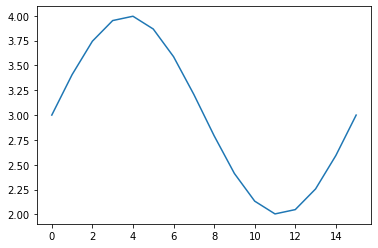

In [2]:
x = np.arange(16)
x = 2*np.pi*x/15
x = np.sin(x)+3
plt.pyplot.plot(x)

Filter 1: $y_k = x_{k+1} - x_k$



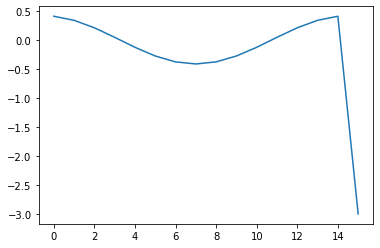

In [3]:
y = np.pad(x , (0,1))[1:] - x
plt.pyplot.plot(y)

Filter 2:  $y_k=x_k-\bar{X}$ where $\bar{X}=\frac{1}{L+1} \sum_{i=0}^L x_i$


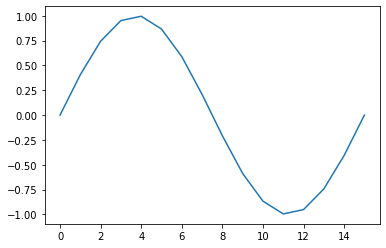

In [4]:
y = x - np.mean(x)
plt.pyplot.plot(y)

Filter 3: $y_k=\operatorname{median}\left(\left\{x_l: l \in[k-2: k+2]\right\}\right)$

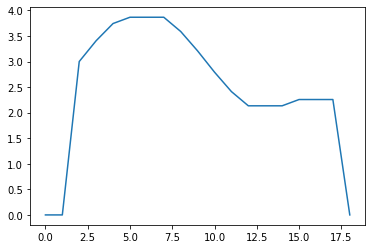

In [5]:
X = np.pad(x , (4,4))
y = np.zeros(19) # Non zero k for [-2 , 17] 
for i in range(19):
  y[i] = np.median(X[i:i+5])
plt.pyplot.plot(y)


Filter 4: $y_k=x_{k+0.5}-x_{k-0.5}$

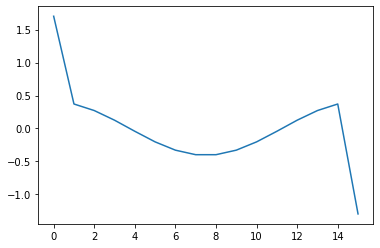

In [6]:
y = np.zeros(16)
X = np.pad(x , (1,1))
x_inter = interpolate.interp1d(np.arange(-1 , 17) , X)
for i in range(16):
  y[i] = x_inter(i+0.5) - x_inter(i-0.5)
plt.pyplot.plot(y)


Filter 5: $|y_k=x_{k+0.5}-x_{k-0.5}|$

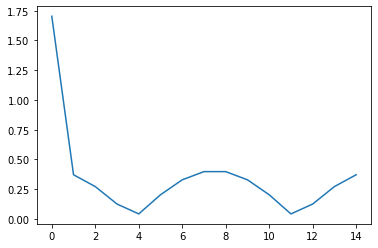

In [7]:
y = np.zeros(15)
X = np.pad(x , (1,1))
x_inter = interpolate.interp1d(np.arange(-1 , 17) , X)
for i in range(15):
  y[i] = np.abs(x_inter(i+0.5) - x_inter(i-0.5))
plt.pyplot.plot(y)


Filter 4: $\frac{1}{5} \sum_{i=k-2}^{k+2} x_i$

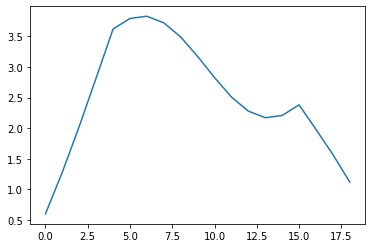

In [8]:
X = np.pad(x , (4,4))
y = np.zeros(19) # Non zero k for [-2 , 17] 
for i in range(19):
  y[i] = 1/5*np.sum(X[i:i+5])
plt.pyplot.plot(y)

Filters 1 , 4 , 6 are linear and space-invariant

With Convolution

Filter 1

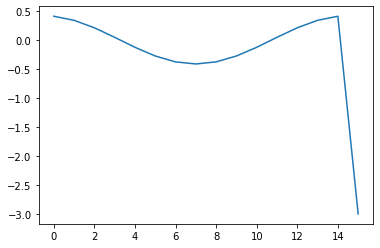

In [9]:
f = np.array([1,-1])
y = np.convolve(x, f, mode='full')[1:]
plt.pyplot.plot(y)


Filter 2

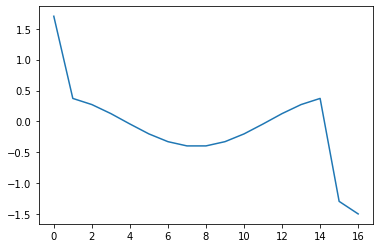

In [10]:
f = np.array([0.5 , 0 , -0.5])
y = np.convolve(x, f, mode='full')[1:]
plt.pyplot.plot(y)


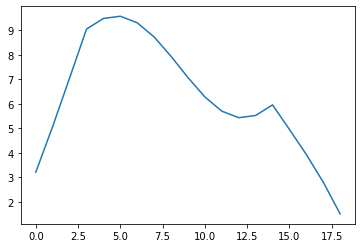

In [11]:
f = np.array([1 , 1 ,1 , 1,1])*0.5
y = np.convolve(x, f, mode='full')[1:]
plt.pyplot.plot(y)


From the Plots, We can verify that the results are same

# Filtering in Fourier Space

Filter 1

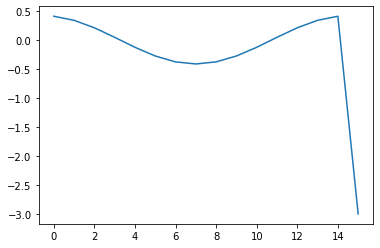

In [12]:
f = np.array([1,-1])
out_shape = x.shape[0]+f.shape[0]-1
X_ft = np.fft.rfft(x, out_shape)
f_ft = np.fft.rfft(f, out_shape)
y = np.fft.irfft(X_ft * f_ft, out_shape)[1:]

plt.pyplot.plot(y)



The results match

Filter 4

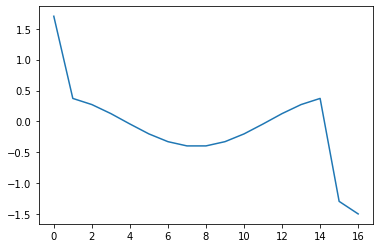

In [13]:
f = np.array([0.5,0 , -0.5])
out_shape = x.shape[0]+f.shape[0]-1
X_ft = np.fft.rfft(x, out_shape)
f_ft = np.fft.rfft(f, out_shape)
y = np.fft.irfft(X_ft * f_ft, out_shape)[1:]

plt.pyplot.plot(y)



The Results Match

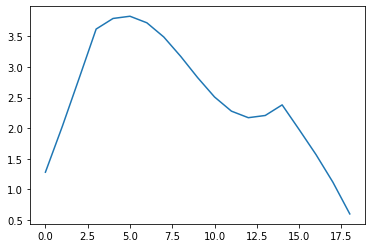

In [14]:
f = np.ones(5)*1/5
out_shape = x.shape[0]+f.shape[0]-1
X_ft = np.fft.rfft(x, out_shape)
f_ft = np.fft.rfft(f, out_shape)
y = np.fft.irfft(X_ft * f_ft, out_shape)[1:]

plt.pyplot.plot(y)



The Results Match

# Hybrid Images

In [15]:
def my_filter(image , filter):
  filterSize = filter.shape
  if filterSize[0] % 2 != 1 or filterSize[0] != filterSize[1]:
    raise Exception('Invalid Filter Size')
  out = cv.filter2D(image , -1 , filter )
  return out

In [16]:
def gen_gaus_kernel(std , kSize):
  filter = cv.getGaussianKernel(kSize , std)
  filter = np.matmul(filter , filter.T)  
  return filter


In [49]:
def load_display_image(path):
  image = cv.imread(path)
  image = image.astype(float)/255
  print()
  print('Input Image')
  print()
  cv2_imshow(image*255)
  # plt.pyplot.imshow(image , cmap = 'brg')
  # plt.pyplot.title('Input Image')
  # plt.pyplot.show()
  return image


In [50]:
def remove_high_freq(image , filter , display = True):
  out = my_filter(image , filter)
  out = np.clip(out , 0 , 1)
  if display:
    print()
    print('Low frequency Image')
    print()
    cv2_imshow(out*255)
    # plt.pyplot.imshow(out)
    # plt.pyplot.title('Blurred Image')
    # plt.pyplot.show()
  return out

In [51]:
def remove_low_freq(image , out):
  out = image - out
  out = np.clip(out , 0 , 1)
  print()
  print('High Freq Image')
  print()
  cv2_imshow(out*255)
  # plt.pyplot.imshow(out)
  # plt.pyplot.title('High Freq Image')
  # plt.pyplot.show()
  return out


In [36]:
def vis_hybrid_image(hybrid_image):
    """
    Visualize a hybrid image by progressively downsampling the image and
    concatenating all of the images together.
    """
    scales = 5
    scale_factor = 0.5
    padding = 5
    original_height = hybrid_image.shape[0]
    num_colors = 1 if hybrid_image.ndim == 2 else 3

    output = np.copy(hybrid_image)
    cur_image = np.copy(hybrid_image)
    for scale in range(2, scales+1):
        # add padding
        output = np.hstack((output, np.ones((original_height, padding, num_colors),
                                            dtype=np.float32)))
        # downsample image
        cur_image = rescale(cur_image, scale_factor, mode='reflect', multichannel=True)
        # pad the top to append to the output
        pad = np.ones((original_height-cur_image.shape[0], cur_image.shape[1],
                       num_colors), dtype=np.float32)
        tmp = np.vstack((pad, cur_image))
        output = np.hstack((output, tmp))
    return output

In [63]:
def create_hybrid_image(path1 , path2 , ksize , std):
  filter = gen_gaus_kernel(std , ksize)
  plt.pyplot.imshow(filter , cmap = 'gray')
  plt.pyplot.title('Low Pass Filter Used')
  plt.pyplot.show()
  print()
  image1 = load_display_image(path1)
  print()
  lowFreqImage = remove_high_freq(image1 , filter , display = True)
  print()
  image2 = load_display_image(path2)
  out = remove_high_freq(image2 , filter , display = False)
  highFreqImage = remove_low_freq(image2 , out) + 0.5
  hybridImage = (highFreqImage + lowFreqImage)*0.5
  # print(hybridImage)
  hybridImage = np.clip(hybridImage , 0 , 1)
  print()
  print('Hybrid Image')
  print()
  cv2_imshow(hybridImage*255)
  print()
  out = vis_hybrid_image(hybridImage)
  cv2_imshow(out*255)
  # plt.pyplot.imshow(hybridImage)
  # plt.pyplot.show()


EXP1

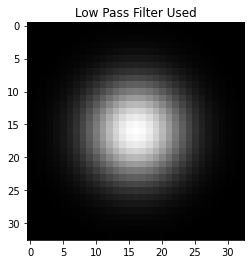



Input Image



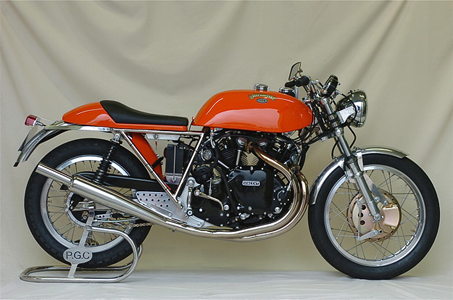



Low frequency Image



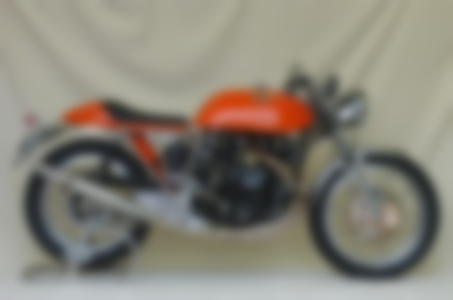



Input Image



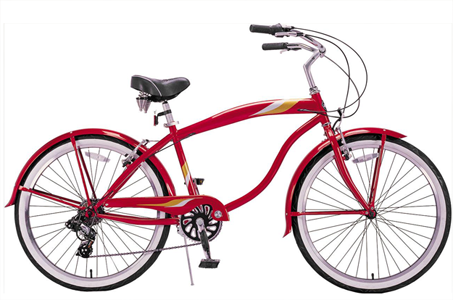


High Freq Image



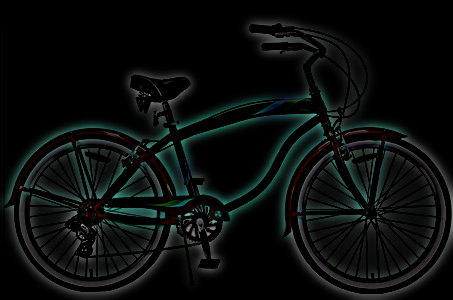


Hybrid Image



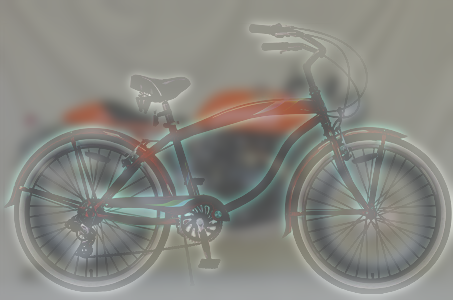

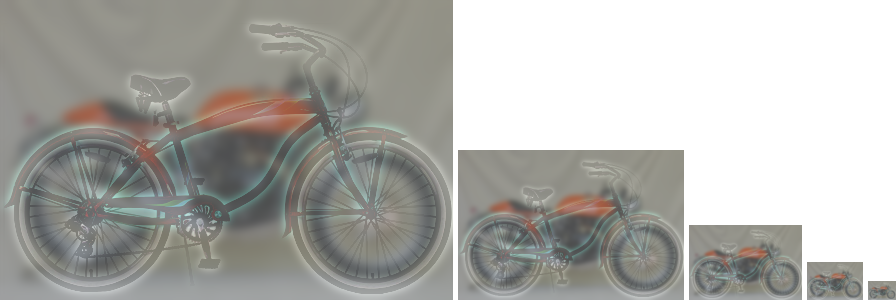

In [65]:
create_hybrid_image('/content/motorcycle.bmp' , '/content/bicycle.bmp' , 33 , 5)

EXP02

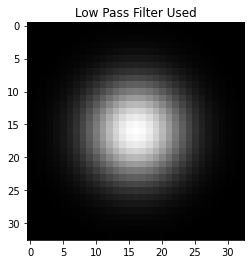



Input Image



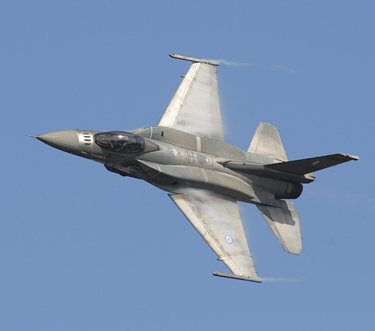



Low frequency Image



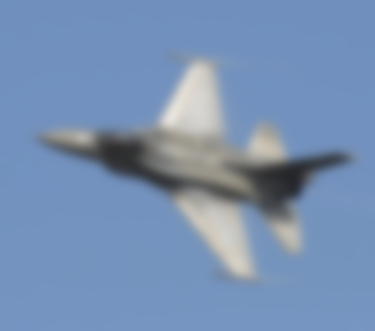



Input Image



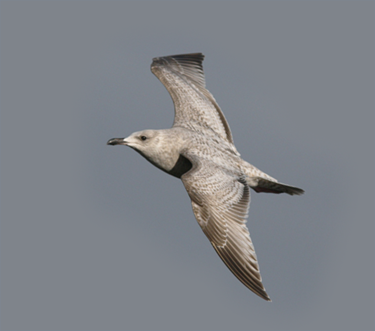


High Freq Image



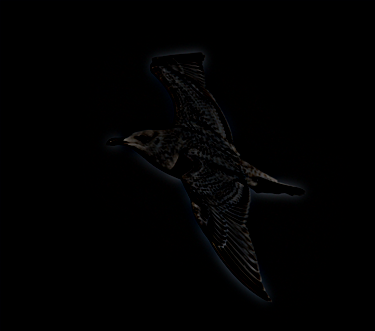


Hybrid Image



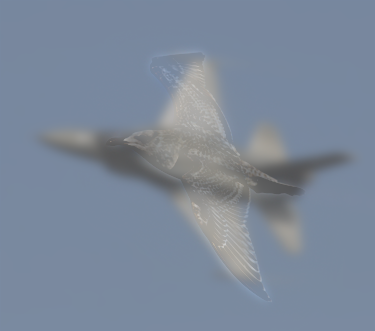

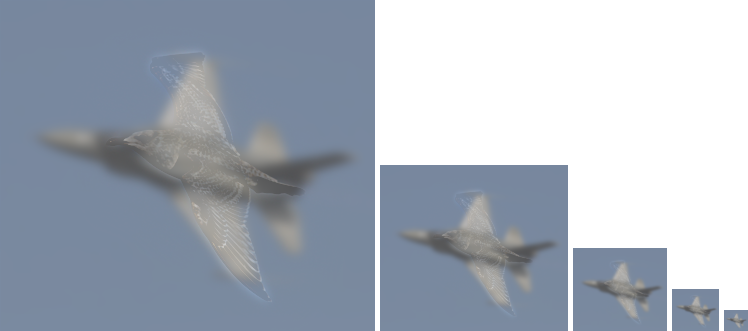

In [66]:
create_hybrid_image('/content/plane.bmp' , '/content/bird.bmp' , 33 , 5)

EXP03

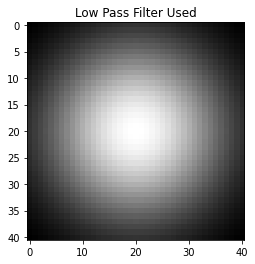



Input Image



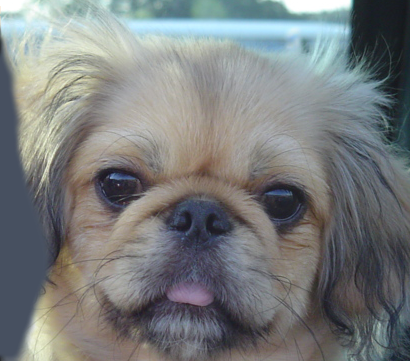



Low frequency Image



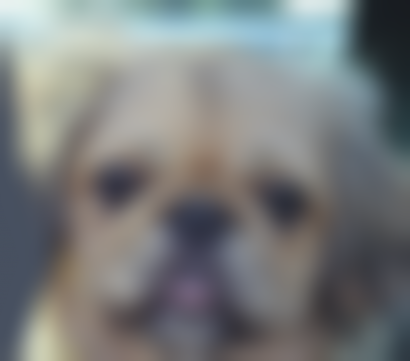



Input Image



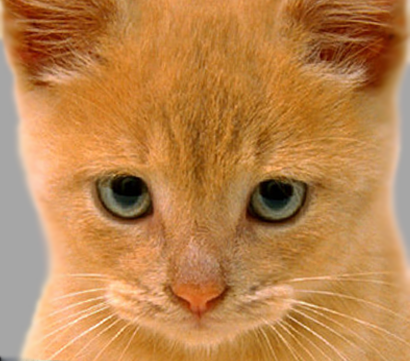


High Freq Image



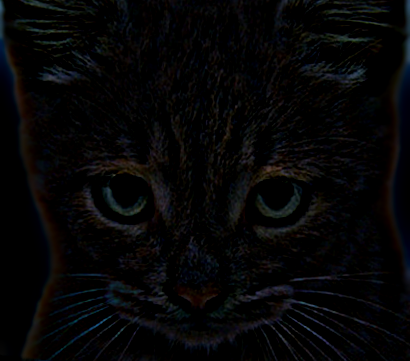


Hybrid Image



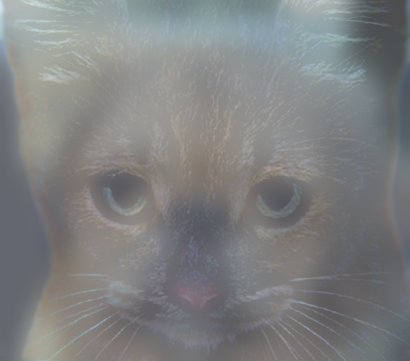

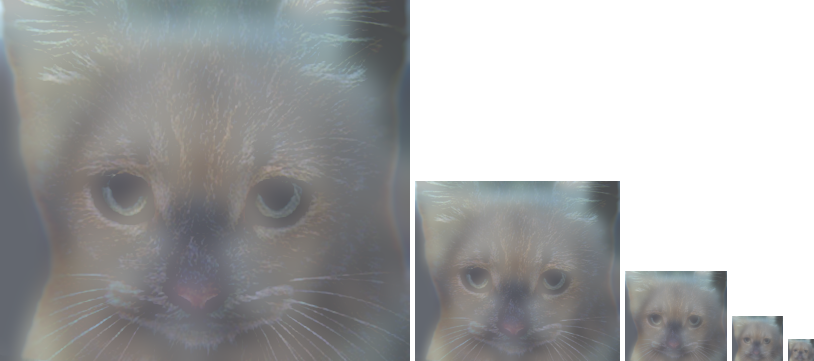

In [76]:
create_hybrid_image('/content/dog.bmp' , '/content/cat.bmp' , 41 , 12)

EXP04

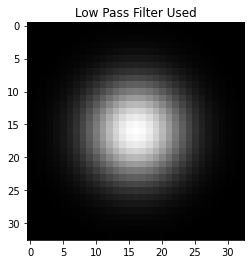



Input Image



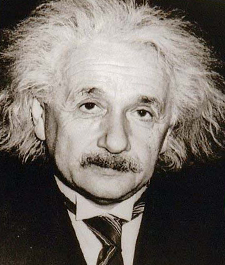



Low frequency Image



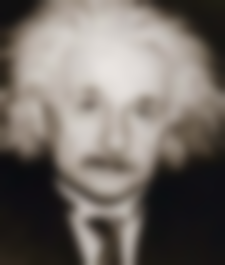



Input Image



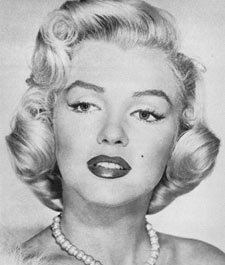


High Freq Image



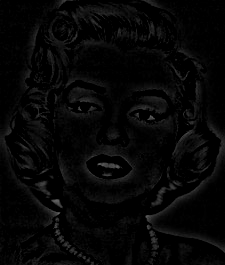


Hybrid Image



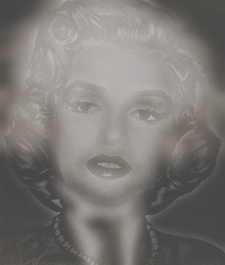

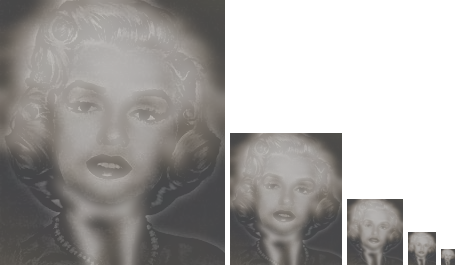

In [78]:
create_hybrid_image('/content/einstein.bmp' , '/content/marilyn.bmp' , 33 , 5)

EXP05

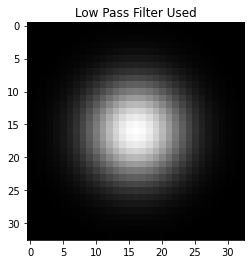



Input Image



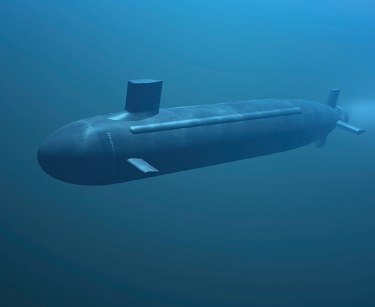



Low frequency Image



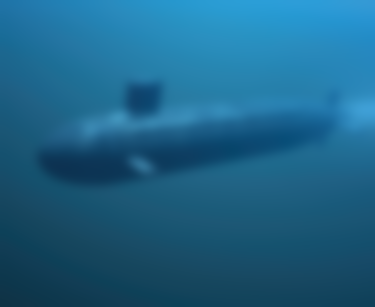



Input Image



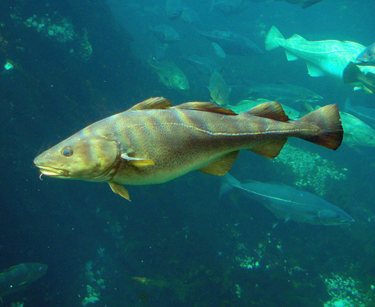


High Freq Image



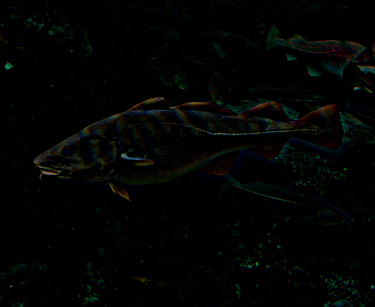


Hybrid Image



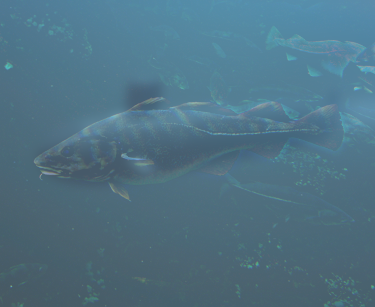

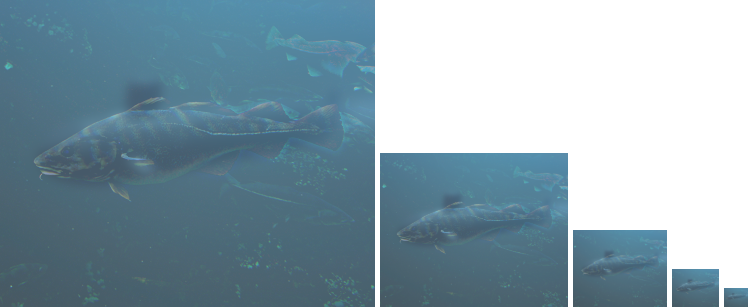

In [83]:
create_hybrid_image('/content/submarine.bmp' , '/content/fish.bmp' , 33 , 5)

EXP06

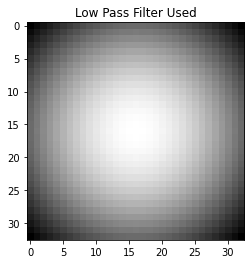



Input Image



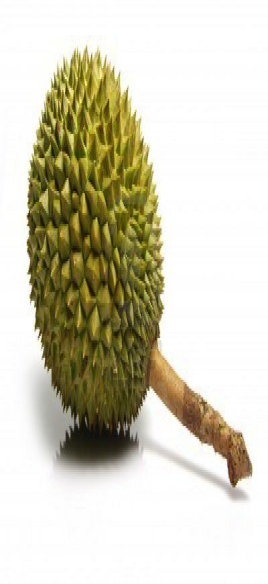



Low frequency Image



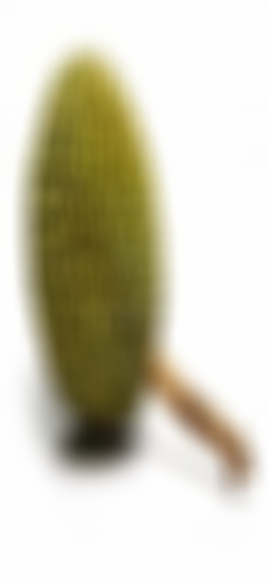



Input Image



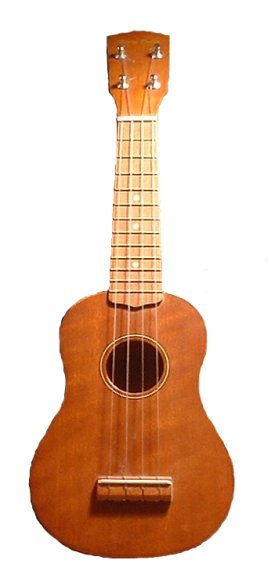


High Freq Image



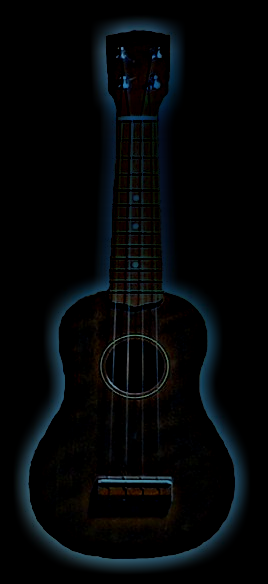


Hybrid Image



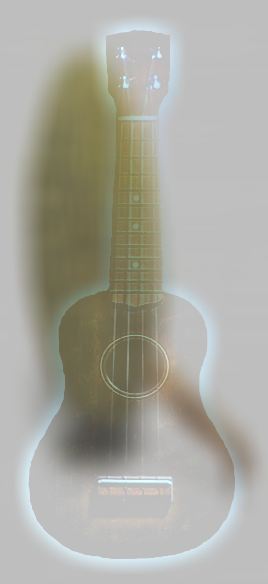

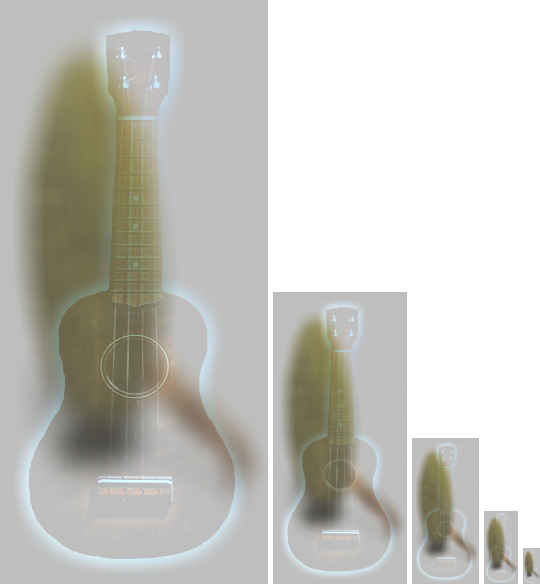

In [89]:
create_hybrid_image('/content/durian_r.jpg' , '/content/ukulele.jpg' , 33 , 20)